# Homework 2
### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18


## Problem

Using the functions shown in class (and copied below), examine the accuracy of various ways to estimate the flux of an object. In particular:

1. Generate a few (say, three) simulated image of a star using the `simulatedImage` function for different seed values, and visualize them using plotCutout. Run `psfPhot` and `apPhot` on the results of each image, and print the estimated flux.

2. Write a function `centerPhot` that uses the value of the central pixel as the estimator of the total magnitude of the object. What is the result? Is that estimator biased?

3. Generate a thousand different simulated images using `simulatedImage`, and compute `centerPhot`, `psfPhot`, and `apPhot` for each simulated image. Plot the histogram of estimates for each (three histogram in total), as well as the mean (using `np.average`) and standard deviation (with `np.std`).

4. Some of the estimators above will be (very) biased, and standard deviations (which are the measure of the accuracy of the estimate) are not directly comparable. To make them comparable, multiply each of them by `Atrue/Amean` (where `Amean` is the mean computed above). This mimics what would happen if we were to remove the bias by calibrating with standard stars. What do you observe about the recalibrated widths of the histograms? Which one is the narrowest, and why?

## Solution

In [1]:
%matplotlib inline

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)

import numpy as np
import math
import matplotlib.pyplot as plt

def makePSF(shape, x0, y0, sigmaPSF):
    # Add a (Gaussian) PSF of width sigmaPSF, centered on (x0, y0)
    xx = np.arange(shape[0]) - shape[0]/2.+0.5
    yy = np.arange(shape[1]) - shape[1]/2.+0.5
    
    r = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    psf = np.exp(-r**2./2./sigmaPSF) / (2*math.pi*sigmaPSF)
    return psf

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] / 2.

    if title is None:
        title = "min = %.0f, max=%.0f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(200, 400)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [2]:
Atrue = 1000.0    # the source count normalization
xdim = 15         # width of the image
ydim = 15         # height of the image
muXtrue = 0.0     # source x centroid 
muYtrue = 0.0     # source y centroid
sigmaPSF = 1.5    # in pixels, corresponds to seeing = 1.5*0.2*2.355 = 0.7 arcsec for LSST (0.2" pix)
skyBg = 250.0     # sky background

In [3]:
def simulatedImage(seed):
    np.random.seed(seed)

    image = np.zeros((xdim, ydim))
    image = Atrue * makePSF(image.shape, 0, 0, sigmaPSF)
    image += skyBg
    image = np.random.poisson(image)
    
    return image

### Task 1

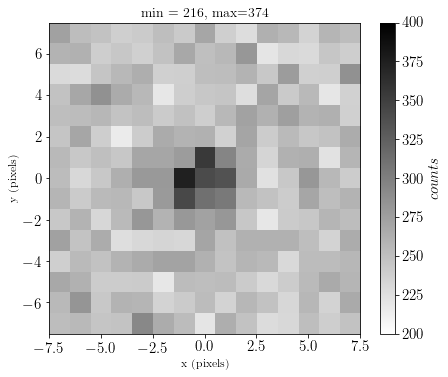

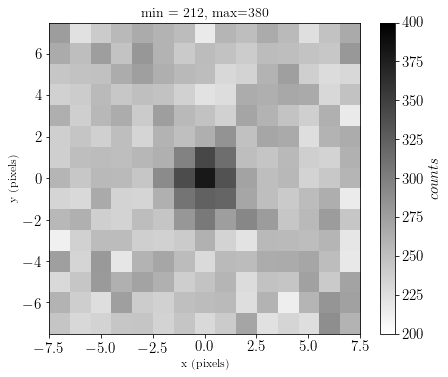

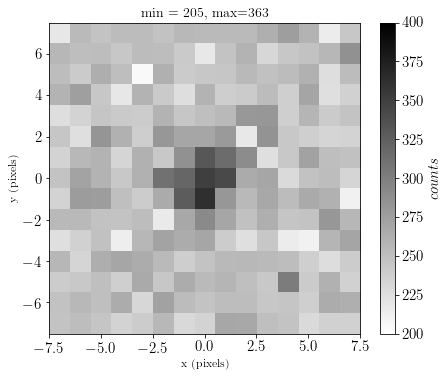

In [4]:
for i in range(3):
    image = simulatedImage(i)
    plotCutout(image)

### Task 2

In [5]:
def apPhot(image, r = 3, x0=0, y0=0):
    # Compute the aperture magnitude
    xx = np.arange(image.shape[0]) - image.shape[0]/2.+0.5
    yy = np.arange(image.shape[1]) - image.shape[1]/2.+0.5
    
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = image - skyBg
    apPhotImage[rpix > r] = 0

    return apPhotImage.sum()

def psfPhot(image, Amin = 600, Amax = 1400):
    # Estimate the noise in the image
    sigmaNoise = np.sqrt(image)

    # Subtract the background (we assume we've estimated it somehow)
    image = image - skyBg
    
    sigmaNoise = np.sqrt(skyBg)

    # search for best flux by gridding
    testA = np.arange(Amin, Amax)
    chi2dof = np.empty(testA.shape)
    best = (np.nan, np.inf)
    psf = makePSF(image.shape, 0, 0, sigmaPSF)
    for i, A in enumerate(testA):
        model = A*psf
        chi2 = np.sum(((image-model)/sigmaNoise)**2)
        chi2dof[i] = chi2 / (image.size - 1)
        if chi2dof[i] < best[1]:
            best = (A, chi2dof[i])
    return best[0]

In [6]:
def centerPhot(image):
    cx = image.shape[0] // 2
    cy = image.shape[1] // 2
    return image[cx, cy] - skyBg

In [7]:
print(centerPhot(image))

100.0


The estimator is very biased. This is equivalent to the aperture magnitude estimator with a very small radius.

### Task 3 / 4

centerPhot 107.736 19.0 , equivalent to 1000 +/- 176.357
apPhot 952.966 89.0 , equivalent to 1000 +/- 93.393
psfPhot 1003.071 78.0 , equivalent to 1000 +/- 77.761


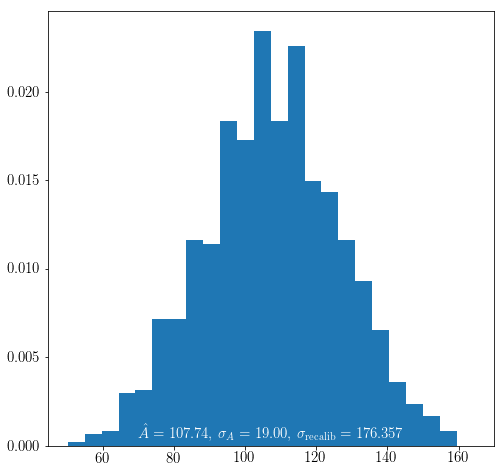

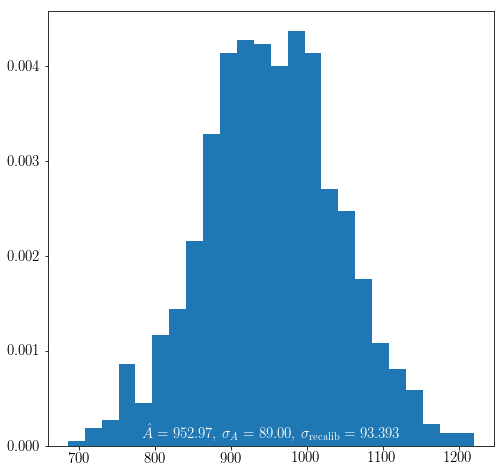

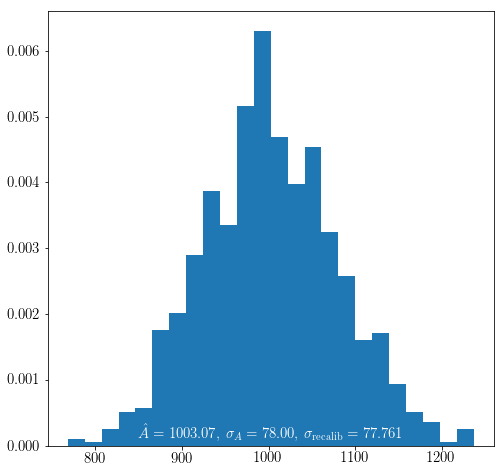

In [8]:
def runSimulation(photMethod, repeats=1000):
    A = np.empty(repeats, float)
    for i in range(A.size):
        image = simulatedImage(i)
        A[i] = photMethod(image)

    Amean = np.average(A)
    Astdev = np.floor(np.std(A))

    return Amean, Astdev, A

def makeHist(photMethod):
    Amean, Astdev, A = runSimulation(photMethod, 1000)
    bins = np.linspace(Amean - 3*Astdev, Amean + 3*Astdev, 25)-0.5
    fig, ax = plt.subplots(figsize=(8,8))
    n, bins, patches = ax.hist(A, bins, normed=True)
    ax.text(0.5, 0.025, r"$\hat A = %.2f$, $\sigma_A = %.2f$, $\sigma_{\rm recalib} = %.3f$" % (Amean, Astdev, Astdev * Atrue / Amean), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='white')

    print(photMethod.__name__, Amean, Astdev, ', equivalent to %.0f +/- %.3f' % (Atrue, Astdev * Atrue / Amean))

makeHist(centerPhot)
makeHist(apPhot)
makeHist(psfPhot)